# **Training a Baseline CNN Model with Regional Multi-Year SST Maps**

by Ding

Connect Google Drive.

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Load the saved preprocessed datasets.

In [2]:
import json

with open('/gdrive/My Drive/GODAS/data_sets.txt', 'r') as in_file:
    data_sets = json.load(in_file)

In [3]:
import numpy as np

train_set_3 = np.array(data_sets[0])
val_set_3 = np.array(data_sets[1])
train_label = np.array(data_sets[2])
val_label = np.array(data_sets[3])

We use PyTorch as the deep learning framework in the TAIAO project.

Import the libraries.

In [4]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from torch.autograd import Variable

Combine data and labels in tuples.

Convert the numpy array type into the PyTorch tensor type.

In [5]:
train_data = []
val_data = []

for i in range(len(train_set_3)):
  train_data.append((torch.from_numpy(train_set_3[i]), train_label[i]))

for i in range(len(val_set_3)):
  val_data.append((torch.from_numpy(val_set_3[i]), val_label[i]))

Check their sizes.

In [6]:
print(len(train_data))
print(len(val_data))

391
95


Activiate GPUs.

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

For PyTorch, set important parameters for the model ahead, including the number of training epoches, the batch size and the learning rate.

In [8]:
EPOCH = 20
BATCH_SIZE = 8
LR = 0.00001

Create data loader using the defined batch size.

Look at their type.

In [9]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_all_loader = Data.DataLoader(dataset=train_data, batch_size=391, shuffle=False)
val_loader = Data.DataLoader(dataset=val_data, batch_size=95, shuffle=False)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


Create the architecture of a baseline CNN model.

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
        )
        self.out = nn.Linear(32 * 15 * 5, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x 

Make the data type double instead of float.

Look at the architecture.

In [11]:
cnn = CNN().double()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (out): Linear(in_features=2400, out_features=1, bias=True)
)


Use [NN-SVG](http://alexlenail.me/NN-SVG/LeNet.html) to visualize the architecture.

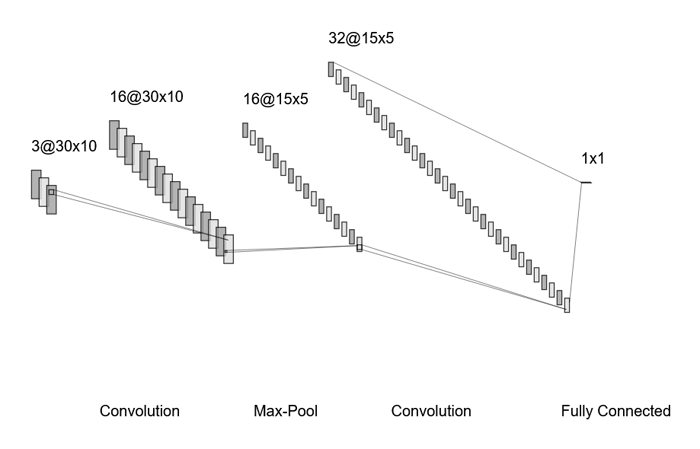

Use the Adam (adaptive moment estimation) optimizer and the MSE (mean squared error) loss function.

In [12]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.MSELoss() 

Train the model and print the training MSEs and validation MSEs.

In [13]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(b_x)[0]
        output = output.reshape(-1) # To avoid different sizes
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for step, (x, y) in enumerate(train_all_loader):
        c_x = Variable(x)
        c_y = Variable(y)

    for step, (x, y) in enumerate(val_loader):
        d_x = Variable(x)
        d_y = Variable(y)

        if step % 100 == 0:
            
            pred_train_y, last_layer = cnn(c_x)
            train_y = torch.Tensor(train_label).double()
            train_mse = ((pred_train_y - c_y) ** 2).sum().item() / float(train_y.size(0))

            pred_val_y, last_layer = cnn(d_x)
            val_y = torch.Tensor(val_label).double()
            val_mse = ((pred_val_y - d_y) ** 2).sum().item() / float(val_y.size(0))

            print('Epoch: ', epoch, '| trainig loss: %.4f' % loss.data, '| training MSE: %.4f' % train_mse, '| validation MSE: %.4f' % val_mse)

Epoch:  0 | trainig loss: 69769.2165 | training MSE: 26968893.0993 | validation MSE: 6590772.0442
Epoch:  1 | trainig loss: 50457.1583 | training MSE: 19818958.9332 | validation MSE: 4843285.2715
Epoch:  2 | trainig loss: 32561.3855 | training MSE: 12584392.2714 | validation MSE: 3075481.4998
Epoch:  3 | trainig loss: 15676.6704 | training MSE: 5893865.9711 | validation MSE: 1440462.9496
Epoch:  4 | trainig loss: 4319.2587 | training MSE: 1647764.6961 | validation MSE: 402750.7220
Epoch:  5 | trainig loss: 470.7751 | training MSE: 190199.5144 | validation MSE: 46494.2836
Epoch:  6 | trainig loss: 14.2631 | training MSE: 7781.5861 | validation MSE: 1896.4865
Epoch:  7 | trainig loss: 3.7093 | training MSE: 2959.1919 | validation MSE: 717.1615
Epoch:  8 | trainig loss: 5.2699 | training MSE: 2943.3729 | validation MSE: 713.3541
Epoch:  9 | trainig loss: 2.1527 | training MSE: 2943.6452 | validation MSE: 713.4722
Epoch:  10 | trainig loss: 4.8365 | training MSE: 2944.1597 | validation MSE

Check the predicted means in the validation set.

In [14]:
print(type(pred_val_y))
print(pred_val_y.shape)
print(pred_val_y)

<class 'torch.Tensor'>
torch.Size([95, 1])
tensor([[290.0267],
        [291.3762],
        [292.3142],
        [292.2808],
        [291.4465],
        [290.0546],
        [288.7512],
        [287.8063],
        [287.3165],
        [287.1931],
        [287.7561],
        [288.7372],
        [289.9422],
        [291.3126],
        [292.0894],
        [292.4634],
        [291.6902],
        [290.6679],
        [289.2382],
        [288.3423],
        [287.7090],
        [287.6417],
        [288.1249],
        [289.2622],
        [290.4719],
        [291.6375],
        [291.9806],
        [291.6802],
        [290.7289],
        [289.5606],
        [288.4902],
        [287.6337],
        [287.2475],
        [287.5720],
        [288.4873],
        [289.9199],
        [291.3100],
        [292.6422],
        [293.3899],
        [293.2887],
        [292.3345],
        [290.9632],
        [289.6143],
        [288.5366],
        [288.0043],
        [287.8348],
        [288.2320],
        [289.1114

Check the observed means in the validation set.

In [15]:
print(type(d_y))
print(d_y.shape)
print(d_y)

<class 'torch.Tensor'>
torch.Size([95])
tensor([292.6270, 292.9124, 291.4956, 289.8936, 288.7509, 287.8133, 287.1520,
        287.2614, 287.4991, 288.5917, 290.0139, 290.9697, 292.4995, 292.7191,
        292.0537, 290.1728, 289.4134, 288.2335, 287.5454, 287.5977, 287.9864,
        288.7764, 290.7270, 291.7558, 292.0813, 291.7614, 290.8811, 289.4242,
        288.2771, 287.7283, 287.0913, 287.1914, 288.5931, 289.8956, 291.2717,
        292.7054, 293.7756, 293.5635, 292.3220, 290.9202, 289.6225, 288.4224,
        287.6997, 288.0254, 288.0903, 288.7024, 290.4198, 292.0933, 291.9690,
        292.4908, 291.7762, 290.6278, 289.6574, 288.6199, 287.7987, 287.1426,
        288.2121, 290.0118, 291.9448, 292.9832, 292.7974, 292.4410, 291.2801,
        289.8629, 288.6522, 287.6669, 286.9484, 286.8079, 287.8829, 289.1476,
        290.9206, 293.0530, 293.0042, 292.6736, 291.3793, 289.9646, 288.4021,
        287.7853, 286.9063, 286.7611, 287.7340, 288.6528, 289.6205, 291.9718,
        292.4319, 291.76

Define a plotting function.

Convert the PyTorch tensors into numpy arrays before plotting.

In [16]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def plot_data(pred_y, real_y):
  pred_y = np.squeeze(pred_y.detach().cpu().numpy())

  fig, ax = plt.subplots(figsize=(9, 9))

  ax.set_xlim([284, 295])
  ax.set_ylim([284, 295])
  plt.xlabel('Observed Regional Average SST', fontsize=20)
  plt.ylabel('Predicted Regional Average SST', fontsize=20)
  ax.plot(real_y, pred_y, 'o', color='black')

  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)

Plot the predicted values and obeserved values in the validation dataset.

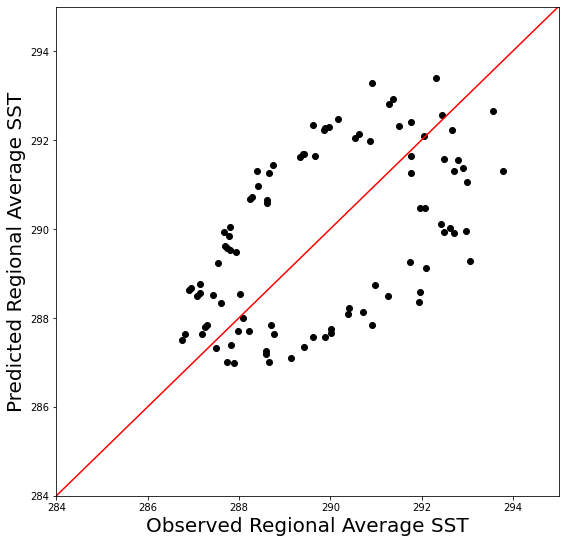

In [17]:
plot_data(pred_val_y, val_label)

Plot the predicted values and obeserved values in the training dataset.

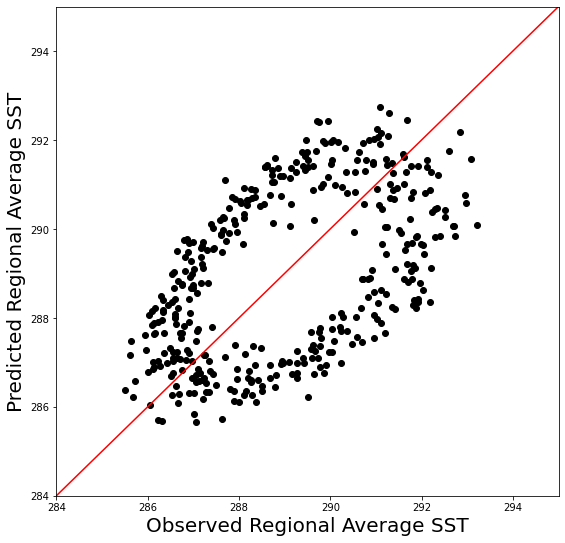

In [18]:
plot_data(pred_train_y, train_label)

Use [the NSE metric](https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient) to evalute the model.

In [20]:
def nse(pred, obs):
  pred_t = np.squeeze(pred.detach().cpu().numpy())[1:]
  obs_t = np.array(obs)[1:]
  obs_t_minus_1 = np.array(obs)[:-1]
  nse = 1 - (np.sum((pred_t - obs_t)**2) / np.sum((obs_t - obs_t_minus_1)**2))
  print(nse)

-2.175638757126774
-2.2394697669961254
-2.175638757126774
-2.2394697669961254


In [21]:
nse(pred_val_y, val_label)
nse(pred_train_y, train_label)

-2.175638757126774
-2.2394697669961254
